# Tutorial: multiome (scRNA-seq + scATAC-seq) data

We show an example of scRNA-seq data produced by 10X Chromium. 
We are using scATAC-seq data `PBMC from a Healthy Donor - No Cell Sorting (3k)` (3,009 cells and 117,757 features) from [10X Genomics Datasets](https://www.10xgenomics.com/resources/datasets). The test data is directly available from `Peak by cell matrix HDF5 (filtered)` in [here](https://www.10xgenomics.com/resources/datasets/pbmc-from-a-healthy-donor-no-cell-sorting-3-k-1-standard-2-0-0) (registration required).

We use [scanpy](https://scanpy.readthedocs.io/en/stable/) to read/write 10X data. Import numpy and scanpy in addlition to screcode.

In [1]:
import screcode
import numpy as np
import scanpy as sc

Read in the count matrix into an [AnnData](https://anndata.readthedocs.io/en/latest/) object. 

In [2]:
input_filename = 'data/pbmc_unsorted_3k_filtered_feature_bc_matrix.h5'
adata = sc.read_10x_h5(input_filename,gex_only=False)
adata.var_names_make_unique()
adata.layers["Raw"] = adata.X.toarray()
adata

c:\Users\expou\AppData\Local\Programs\Python\Python310\lib\site-packages\anndata\_core\anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 3009 × 117757
    var: 'gene_ids', 'feature_types', 'genome'
    layers: 'Raw'

In [3]:
np.unique(adata.var['feature_types'].values,return_counts=True)

(array(['Gene Expression', 'Peaks'], dtype=object),
 array([36601, 81156], dtype=int64))

## Apply RECODE
Apply RECODE to the count matrix. **Only anndata data format is available for multiome data**. 

In [4]:
recode = screcode.RECODE(seq_target='Multiome')
adata = recode.fit_transform(adata)

start RECODE for Multiome data
end RECODE for scMultiome-seq
log: {'seq_target': 'Multiome', '#significant features': 87901, '#non-significant features': 19119, '#silent features': 10737, 'ell': 102, 'Elapsed time': '0h 2m 22s 304ms', 'solver': 'full', '#test_data': 601}


With anndata format, outputs of RECODE are included in anndata objects:
- denoised matrix -> adata.obsm['RECODE']
- noise variance -> adata.var['noise_variance_RECODE']
- normalized variance (NVSN variance) ->  adata.var['normalized_variance_RECODE']
- clasification of genes (significant/non-significant/silent) ->  adata.var['significance_RECODE']

In [5]:
adata

AnnData object with n_obs × n_vars = 3009 × 117757
    var: 'gene_ids', 'feature_types', 'genome', 'noise_variance_RECODE', 'normalized_variance_RECODE', 'significance_RECODE'
    layers: 'Raw', 'RECODE', 'RECODE_NVSN'

## Performance verification
Show report:

c:\Users\expou\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\expou\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


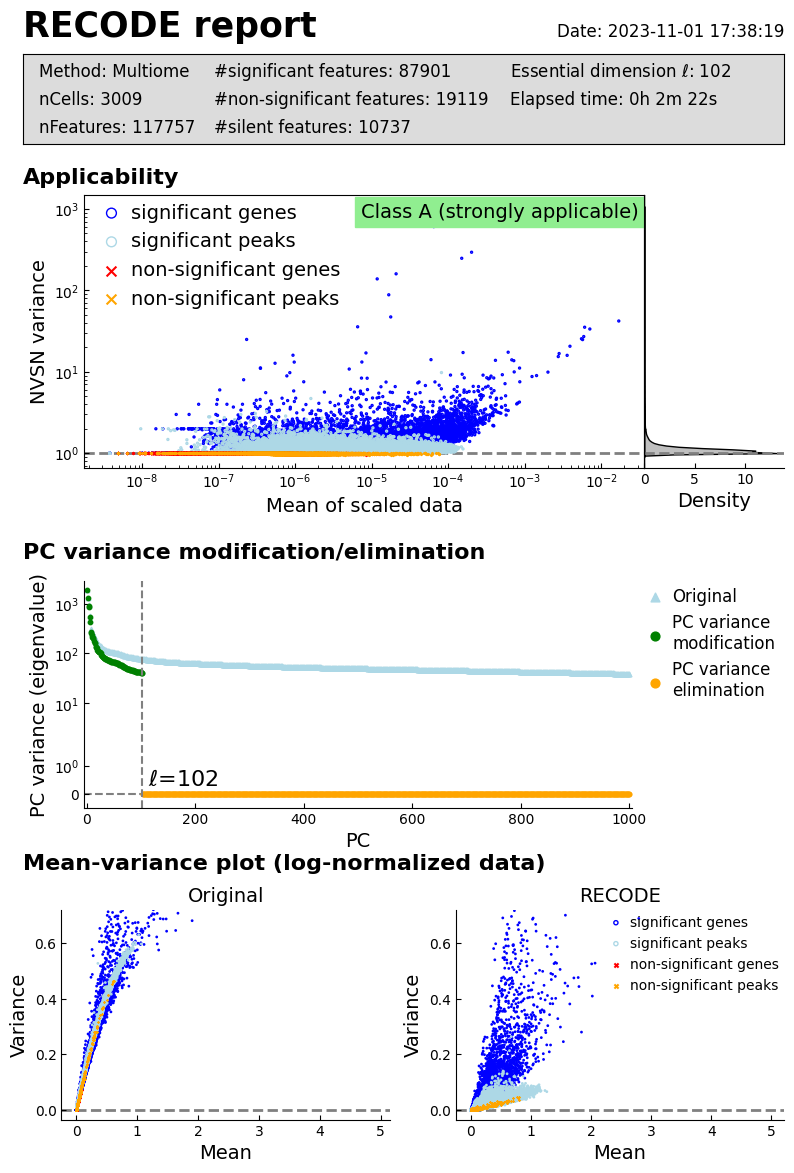

In [6]:
recode.report()

In [24]:
target_sum = 1e6
adata.X = adata.layers["RECODE"]
adata = recode.lognormalize(adata,target_sum=target_sum)
sc.pp.normalize_total(adata, target_sum=target_sum)
sc.pp.log1p(adata)

In [40]:
adata.layers["Raw_log"] = np.log(target_sum*adata.layers["Raw"]/np.sum(adata.layers["Raw"],axis=1)[:,np.newaxis]+1)

In [14]:
import sklearn.decomposition
n_pcs = 50
adata.obsm["X_pca"] = sklearn.decomposition.PCA(n_components=n_pcs).fit_transform(adata.layers["RECODE_log"])

In [25]:
sc.tl.pca(adata, svd_solver='arpack')

c:\Users\expou\AppData\Local\Programs\Python\Python310\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1208: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):


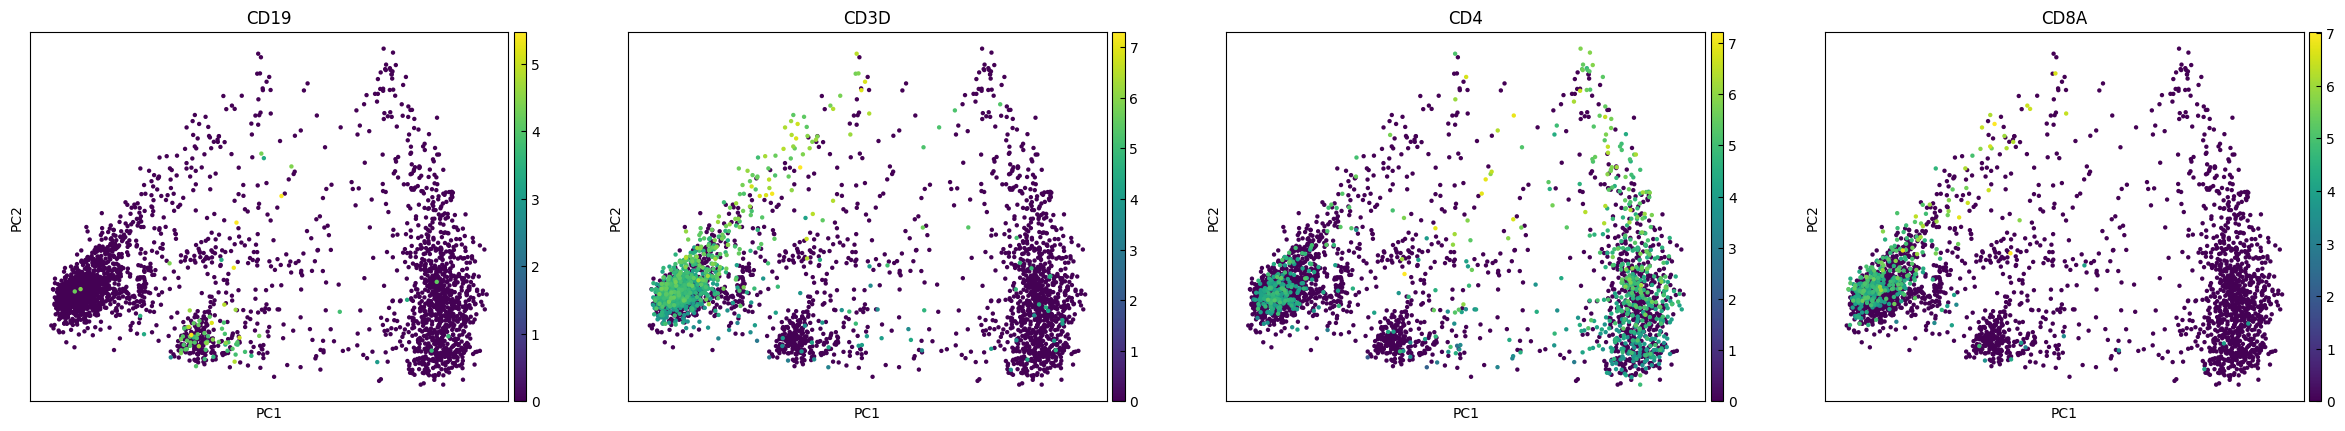

c:\Users\expou\AppData\Local\Programs\Python\Python310\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1208: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):


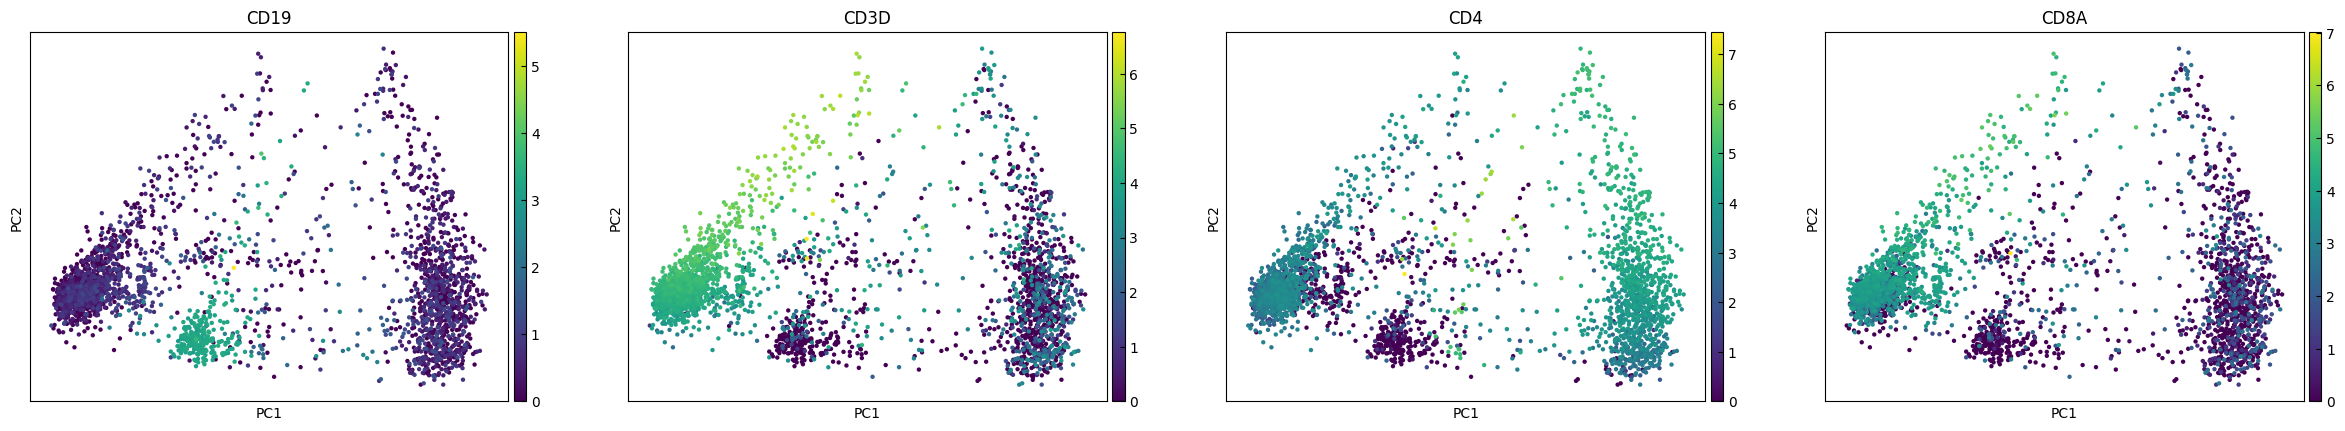

In [41]:
plot_genes = ['CD19','CD3D','CD4','CD8A']
sc.pl.pca(adata, color=plot_genes,layer="Raw_log")
sc.pl.pca(adata, color=plot_genes,layer="RECODE_log")

In [28]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=0)
sc.tl.umap(adata)

c:\Users\expou\AppData\Local\Programs\Python\Python310\lib\site-packages\umap\distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
c:\Users\expou\AppData\Local\Programs\Python\Python310\lib\site-packages\umap\distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
c:\Users\expou\AppData\Local\Programs\Python\Python3

c:\Users\expou\AppData\Local\Programs\Python\Python310\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1208: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):


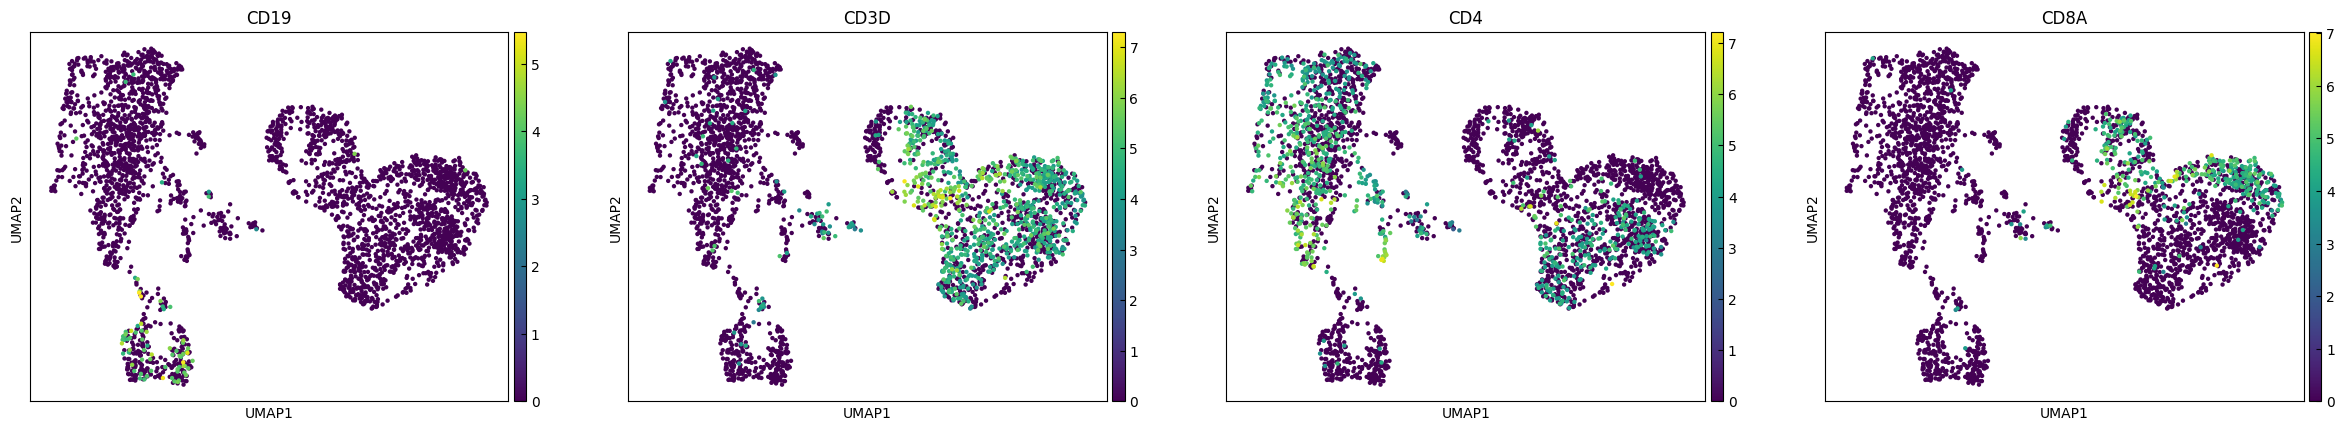

c:\Users\expou\AppData\Local\Programs\Python\Python310\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1208: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):


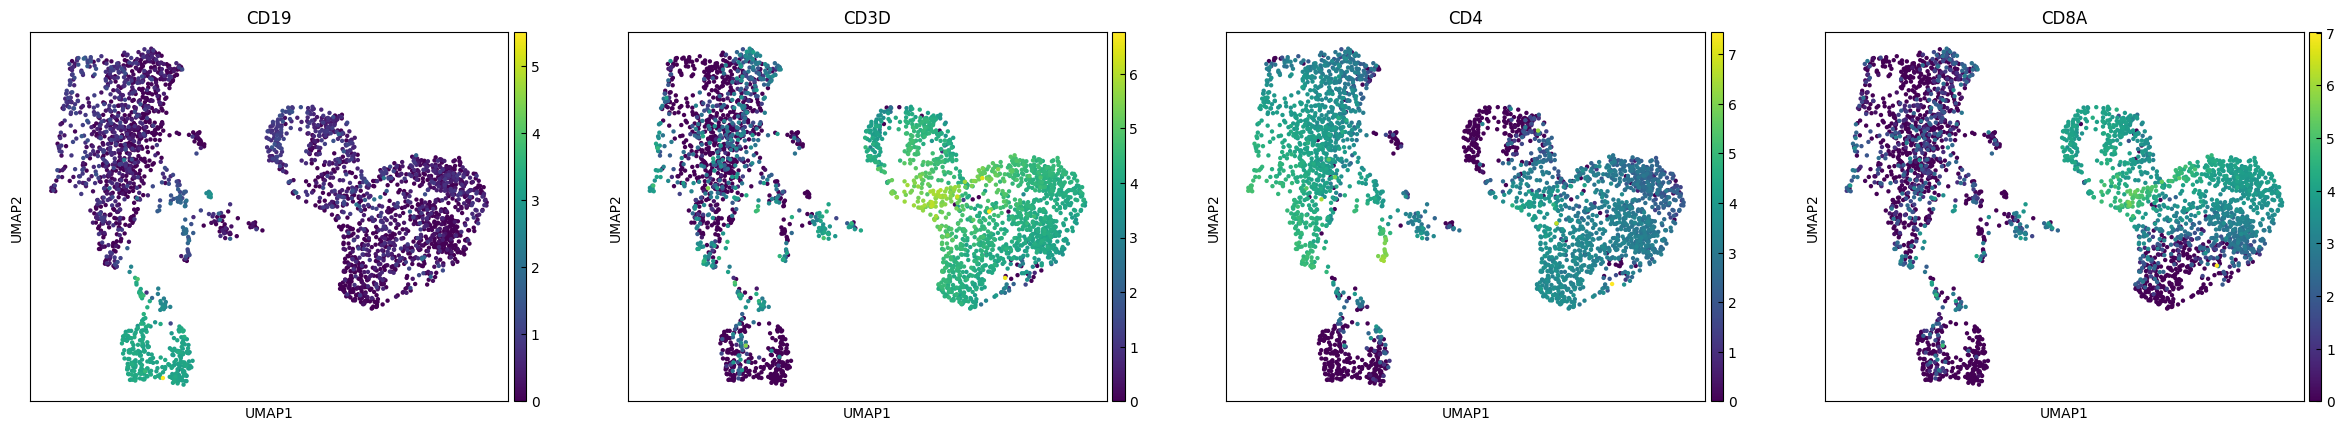

In [42]:
sc.pl.umap(adata, color=plot_genes,layer="Raw_log")
sc.pl.umap(adata, color=plot_genes,layer="RECODE_log")

c:\Users\expou\AppData\Local\Programs\Python\Python310\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1208: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
c:\Users\expou\AppData\Local\Programs\Python\Python310\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
c:\Users\expou\AppData\Local\Programs\Python\Python310\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


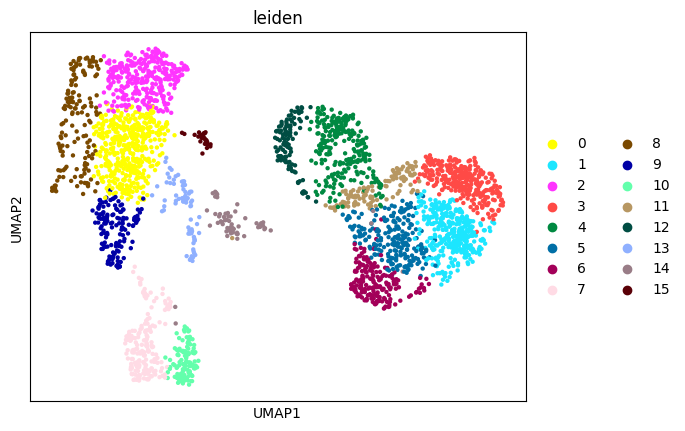

In [47]:
sc.tl.leiden(adata,resolution=1)
sc.pl.umap(adata, color=['leiden'])